In [1]:
import os
import re
import sys
import numpy as np 
import pandas as pd
import scipy as sp
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

sys.path.append('../../')
import warnings
warnings.filterwarnings("ignore")

from src.gaussian_process import Gaussain_Process
from src.kernels import rbf

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Get Data

In [2]:
from stress_optimisation.load_exp_data import stress_resist_data_loader, append_new_data

x_train, stress_y_train, resist_y_train = stress_resist_data_loader()

stress_dir = "/home/ashriva/work/beyond_finger_printing/ankit/Experiments/Data/raw/stress_data/"

for trail in range(3):
    x_new, stress_new, resist_new = append_new_data()
    x_train = np.append(x_train, x_new, axis=0)
    stress_y_train = np.append(stress_y_train, stress_new.reshape(-1, 1), axis=0)
    resist_y_train = np.append(resist_y_train, resist_new.reshape(-1, 1), axis=0)

# Get a gaussian process model

In [3]:
parameter_space = np.array([[2, 23], [50, 750]])

## Stress

In [146]:
l_stress = [1, 1, 0.1]

# Gaussian process interpolator for stress
kernel_stress = rbf(l_stress)
GP_stress = Gaussain_Process(kernel_stress, parameter_space)
GP_stress.add_observation(x_train, stress_y_train, scale=True)

GP_stress.noise = 0.12
# GP_stress.fit()

In [147]:
xx = np.linspace(parameter_space[0][0], parameter_space[0][1], 100)
xx = np.append(xx, [2, 3, 5, 8, 11, 14, 17, 20, 23])
xx = np.unique(xx)

yy = np.linspace(parameter_space[1][0], parameter_space[1][1], 20)
yy = np.append(yy, [100, 500, 750])
yy = np.unique(yy)

# Parameter grid setup
xx, yy = np.meshgrid(xx, yy)
x_test = np.append(xx.reshape(-1, 1),
                    yy.reshape(-1, 1),
                    axis=1)

stress_mu_gp = np.zeros([0,1])
stress_mu_gp_grad = np.zeros([0,1])
stress_sd = np.zeros([0,1])
    
for input_ in x_test:
    mu_, sd_, mu_grad_ = GP_stress.posterior(np.array(input_).reshape(1,-1), calc_grad=True)
    stress_mu_gp = np.append(stress_mu_gp, 
                             mu_.reshape(-1,1), 
                             axis=0)    
    stress_mu_gp_grad = np.append(stress_mu_gp_grad, 
                               mu_grad_.reshape(-1,1), 
                               axis=0)
    stress_sd = np.append(stress_sd, 
                          sd_.reshape(-1,1), 
                          axis=0)

In [148]:
stress_surface = stress_mu_gp

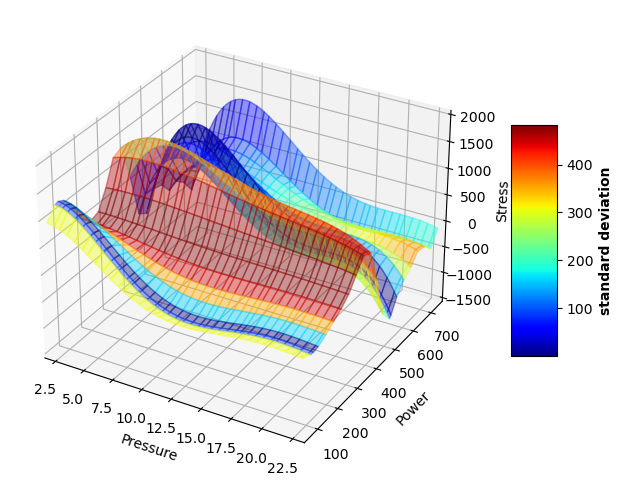

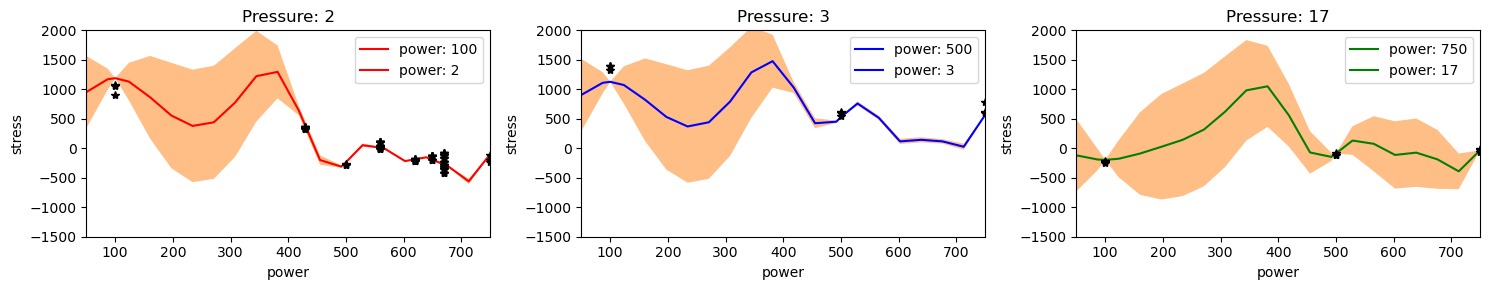

In [149]:
from matplotlib import cm

# 3D view
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10, 6))
scamap = plt.cm.ScalarMappable(cmap='jet')
fcolors = scamap.to_rgba(stress_sd.reshape(yy.shape))
ax.plot_surface(x_test[:,0].reshape(xx.shape), 
                x_test[:,1].reshape(xx.shape), 
                stress_surface.reshape(yy.shape), 
                facecolors=fcolors, cmap='jet', 
                antialiased = True,
                shade=False,
                alpha=.4)
ax.set_xlim(np.min(xx),np.max(xx))
ax.set_ylim(np.min(yy),np.max(yy))
ax.set_zlim(-1500,2000)
ax.set_xlabel("Pressure")
ax.set_ylabel("Power")
ax.set_zlabel("Stress")
cbar = fig.colorbar(scamap, ax = ax, shrink=0.5, aspect=5)
cbar.ax.set_ylabel('standard deviation', fontweight ='bold')
# plt.show()
plt.savefig("analysis/3d_"+str(l_stress[1])+"_"+str(l_stress[2])+".png")


fig, axs = plt.subplots(nrows=1, ncols=3, figsize=[15,3])
# 2D Pressure vs Stress
lcolor = ['r','b', 'g', 'k']
for i, (ax, p) in enumerate(zip(axs.ravel(),[100,500,750])):

    indx = np.isclose(x_test[:,1], p, rtol=1e-05, atol=1e-08, equal_nan=False)
    ax.plot(x_test[indx,0], stress_surface[indx,0], color=lcolor[i], label="power: "+ str(p))
    ax.fill_between(x_test[indx,0], 
                    stress_surface[indx,0]+2*stress_sd[indx,0], 
                    stress_surface[indx,0]-2*stress_sd[indx,0], 
                    alpha=0.5)
    
    indx = np.isclose(x_train[:,1], p, rtol=1e-05, atol=1e-08, equal_nan=False)
    ax.plot(x_train[indx,0], stress_y_train[indx,0], "k*")
    
    ax.set_title("Power: "+ str(p))
    ax.legend()
    ax.set_xlabel("pressure")
    ax.set_ylabel("stress")
    ax.set_ylim(-1500, 2000)
    ax.set_xlim(np.min(xx), np.max(xx))
plt.savefig("analysis/2d_"+str(l_stress[1])+"_"+str(l_stress[2])+".png")

for i, (ax, p) in enumerate(zip(axs.ravel(),[2,3,17])):

    indx = np.isclose(x_test[:,0], p, rtol=1e-05, atol=1e-08, equal_nan=False)
    ax.plot(x_test[indx,1], stress_surface[indx,0], color=lcolor[i], label="power: "+ str(p))
    ax.fill_between(x_test[indx,1], 
                    stress_surface[indx,0]+2*stress_sd[indx,0], 
                    stress_surface[indx,0]-2*stress_sd[indx,0], 
                    alpha=0.5)
    
    indx = np.isclose(x_train[:,0], p, rtol=1e-05, atol=1e-08, equal_nan=False)
    ax.plot(x_train[indx,1], stress_y_train[indx,0], "k*")
    
    ax.set_title("Pressure: "+ str(p))
    ax.legend()
    ax.set_xlabel("power")
    ax.set_ylabel("stress")
    ax.set_ylim(-1500, 2000)
    ax.set_xlim(np.min(yy), np.max(yy))
plt.savefig("analysis/2d_po_"+str(l_stress[1])+"_"+str(l_stress[2])+".png")

# p = 11
# ax=axs.ravel()[-1]
# indx = x_train[:,0] == p
# ax.scatter(x_train[indx,1], stress_y_train[indx])

# indx = np.isclose(x_test[:,0], p, rtol=1e-05, atol=1e-08, equal_nan=False)
# ax.plot(x_test[indx,1], stress_surface[indx], color=lcolor[i], label="pressure: "+ str(p))
# ax.fill_between(x_test[indx,1], 
#                 stress_surface[indx,0]+2*sd[indx,0], 
#                 stress_surface[indx,0]-2*sd[indx,0], 
#                 alpha=0.5)
# ax.legend()
# ax.set_xlabel("power")
# ax.set_ylabel("stress")

plt.tight_layout()
plt.show()

## Resistance

In [ ]:
l_resist = l_stress

# Gaussian process interpolator for resistance
kernel = rbf(l_resist)
GP_resist = Gaussain_Process(kernel, parameter_space)
GP_resist.add_observation(x_train, resist_y_train, scale=True)

GP_resist.noise = .058
GP_resist.fit()

In [ ]:
xx = np.linspace(parameter_space[0][0], parameter_space[0][1], 100)
xx = np.append(xx, [2, 3, 5, 8, 11, 14, 17, 20, 23])
xx = np.unique(xx)

yy = np.linspace(parameter_space[1][0], parameter_space[1][1], 20)
yy = np.append(yy, [100, 500, 750])
yy = np.unique(yy)

# Parameter grid setup
xx, yy = np.meshgrid(xx, yy)
x_test = np.append(xx.reshape(-1, 1),
                    yy.reshape(-1, 1),
                    axis=1)

resist_mu_gp = np.zeros([0,1])
resist_sd = np.zeros([0,1])
    
for input_ in x_test:  
    mu_, sd_ = GP_resist.posterior(np.array(input_).reshape(1,-1))
    resist_mu_gp = np.append(resist_mu_gp, 
                             mu_.reshape(-1,1), 
                             axis=0)
    resist_sd = np.append(resist_sd, 
                          sd_.reshape(-1,1),
                          axis=0)

In [ ]:
resist_surface = resist_mu_gp

In [ ]:
from matplotlib import cm

# 3D view
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10, 6))
scamap = plt.cm.ScalarMappable(cmap='jet')
fcolors = scamap.to_rgba(resist_sd.reshape(yy.shape))
ax.plot_surface(x_test[:,0].reshape(xx.shape), 
                x_test[:,1].reshape(xx.shape), 
                resist_surface.reshape(yy.shape), 
                facecolors=fcolors, cmap='jet', 
                antialiased = True,
                shade=False,
                alpha=.4)

ax.set_xlabel("Pressure")
ax.set_ylabel("Power")
ax.set_zlabel("Resistance")
cbar = fig.colorbar(scamap, ax = ax, shrink=0.5, aspect=5)
cbar.ax.set_ylabel('standard deviation', fontweight ='bold')
plt.show()

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=[15,3])
# 2D Pressure vs Stress
lcolor = ['r','b', 'g', 'k']
for i, (ax, p) in enumerate(zip(axs.ravel(),[100,500,750])):

    indx = np.isclose(x_test[:,1], p, rtol=1e-05, atol=1e-08, equal_nan=False)
    ax.plot(x_test[indx,0], resist_surface[indx,0], color=lcolor[i], label="power: "+ str(p))
    ax.fill_between(x_test[indx,0], 
                    resist_surface[indx,0]+2*resist_sd[indx,0], 
                    resist_surface[indx,0]-2*resist_sd[indx,0], 
                    alpha=0.5)
    
    indx = np.isclose(x_train[:,1], p, rtol=1e-05, atol=1e-08, equal_nan=False)
    ax.plot(x_train[indx,0], resist_y_train[indx,0], "k*")
    
    ax.set_title("Power: "+ str(p))
    ax.legend()
    ax.set_xlabel("pressure")
    ax.set_ylabel("stress")

# p = 11
# ax=axs.ravel()[-1]
# indx = x_train[:,0] == p
# ax.scatter(x_train[indx,1], stress_y_train[indx])

# indx = np.isclose(x_test[:,0], p, rtol=1e-05, atol=1e-08, equal_nan=False)
# ax.plot(x_test[indx,1], stress_surface[indx], color=lcolor[i], label="pressure: "+ str(p))
# ax.fill_between(x_test[indx,1], 
#                 stress_surface[indx,0]+2*sd[indx,0], 
#                 stress_surface[indx,0]-2*sd[indx,0], 
#                 alpha=0.5)
# ax.legend()
# ax.set_xlabel("power")
# ax.set_ylabel("stress")

plt.tight_layout()
plt.show()

In [ ]:
import pickle

# Save the models
with open('models/Known_gp_objects.pkl', 'wb') as outp:
    data = {'stress': GP_stress,
            'resist': GP_resist
           }
    pickle.dump(data, outp, pickle.HIGHEST_PROTOCOL)

# Train Stress neural network model on it

In [ ]:
with open('models/Known_gp_objects.pkl', 'rb') as file:
    data = pickle.load(file)
    GP_stress = data['stress']
    GP_resist = data['resist']

In [ ]:
import sys
sys.path.append('../../../')

import os
import math
import argparse
import logging
import h5py
import numpy as np
import torch
from torchinfo import summary
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from dl_model.src.initialisation import weight_init
from dl_model.utils.helpers import Standardization
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [ ]:
# use_cuda = torch.cuda.is_available()
USE_CUDA = False
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

RESULTDIR = "../../../../Results/bayesopts/"

In [ ]:
def evaluate(model, dataloader):
    """Evaluate trained model

    Args:
        Model (torch module):
        dataset (Dataloader):

    Returns:
        float: loss on dataset
    """
    loss = 0
    model.eval()
    with torch.no_grad():
        for _, (x_input, y_target) in enumerate(dataloader):
            x_input, y_target = x_input.to(DEVICE), y_target.to(DEVICE)
            y_pred = model(x_input)
            loss += model.loss(y_pred, y_target).item()

    loss = loss / len(dataloader)

    return loss


def train(model, dataloader, optimizer):
    """train model at every epoch

    Args:
        model (torch module):
        dataloader (Dataloader):
        optimizer (torch module):

    Returns:
        float: train loss
    """
    model.train()
    total_loss = 0
    for _, (x_input, y_target) in enumerate(dataloader):
        x_input, y_target = x_input.to(DEVICE), y_target.to(DEVICE)

        y_pred = model(x_input)
        loss = model.loss(y_pred, y_target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    return avg_loss

In [ ]:
def setup_logging(args, model):
    """ Creates folder, setup logger and tensorboard writer

    Args:
        args (Namespace):
        model (torch module): _description_

    Returns:
        dict: returns tensorboard writer and file handler
    """
    if not os.path.exists(RESULTDIR + model.name):
        os.makedirs(RESULTDIR + model.name)

    listdir = os.listdir(RESULTDIR + model.name)
    run_name = '/run' + str(len(listdir))
    args.path = RESULTDIR + model.name + run_name + "/"

    if not os.path.exists(args.path):
        os.makedirs(args.path)

    logfilename = args.path + 'train.log'
    handler = logging.FileHandler(logfilename)
    handler.setLevel(logging.DEBUG)
    formatter = logging.Formatter(
        "%(asctime)-15s %(levelname)-8s %(name)s:%(lineno)d \n%(message)s\n")
    handler.setFormatter(formatter)

    logger = logging.getLogger(__name__)
    logger.setLevel(logging.DEBUG)
    logger.addHandler(handler)

    # Log hyperparameters
    config = vars(args)
    logger.info("".join(['{}:\t{}\n'.format(key, value)
                         for key, value in config.items()]))

    logger.info(summary(model,
                        verbose=0,
                        col_width=16))

    # Tensorboard
    writer = SummaryWriter(
        log_dir=args.path + '/tb')

    return {"tensorboard": writer, "file": logger}


def log_results(logger, loss, epoch):
    """Save loss at every checkpoint

    Args:
        logger (dict): tensorboard writer and file handler
        loss (dict): training loss and validation loss for a epoch
        epoch (int):
    """
    exc = "Epoch: {} \tTraining Loss: {:.6f} ".format(
        epoch, train_loss)
    logger['file'].info(exc)
    logger['tensorboard'].add_scalars('Loss', loss, epoch)

In [ ]:
cmd_args = ['--train',"--batch_size","100","--total_epochs","1000"]

PARSER = argparse.ArgumentParser(description='PyTorch MNIST Example')
PARSER.add_argument('--batch_size', type=int, default=64, metavar='N',
                    help='input batch size for training (default: 64)')
PARSER.add_argument('--total_epochs', type=int, default=14, metavar='N',
                    help='number of epochs to train (default: 14)')
PARSER.add_argument('--lr', type=float, default=1e-4, metavar='LR',
                    help='learning rate (default: 1.0)')
PARSER.add_argument('--gamma', type=float, default=0.7, metavar='M',
                    help='Learning rate step gamma (default: 0.7)')
PARSER.add_argument('--checkpoint', type=int, default=2, metavar='N',
                    help='logging training status after specific number of epochs')
PARSER.add_argument('--train', action='store_true', help="Train the model")
PARSER.add_argument('--test', action='store_true',
                    help="Test trained model")
PARSER.add_argument('--path', action='store', type=str,
                    help="path of trained model")
ARGS = PARSER.parse_args(cmd_args)

In [ ]:
# DATA 
## Train the surface on scaled data

dl_train_x = GP_stress.get_scale_x(x_test).astype(np.float32)
dl_train_y_s = GP_stress.get_scale_y(stress_surface).astype(np.float32)
dl_train_y_r = GP_resist.get_scale_y(resist_surface).astype(np.float32)

dl_train_y = np.append(dl_train_y_s,dl_train_y_r,axis=1)

DATALOADER = DataLoader(
            TensorDataset(torch.from_numpy(dl_train_x), 
                          torch.from_numpy(dl_train_y)),
            batch_size=ARGS.batch_size
          )

In [ ]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.name = "Bayes_opt_demo"
        self.network = torch.nn.Sequential(
            torch.nn.Linear(2, 4),
            torch.nn.Linear(4, 16),
            torch.nn.Tanh(),
            torch.nn.Linear(16, 16),
            torch.nn.Tanh(),
            torch.nn.Linear(16, 2),
#             torch.nn.Tanh()
        )

    def forward(self, x_input):
        y_pred = self.network(x_input)
        return y_pred

    def regularization(self):
        l1_penalty = torch.nn.L1Loss()
        reg_loss = 0
        
        lam = 0
        for param in self.parameters():
            reg_loss += lam*l1_penalty(param,torch.zeros(param.shape))
        
        return reg_loss
        
    def loss(self, prediction, target):
        """_summary_

        Args:
            prediction (tensor):
            target (tensor):

        Returns:
            _type_: _description_
        """
        loss = torch.nn.MSELoss()
        return loss(prediction, target)+self.regularization()

In [ ]:
MODEL = Model().to(DEVICE)

In [ ]:
ARGS.lr = .01
ARGS.total_epochs = 10000

In [ ]:
# Model setup and inititalization
MODEL = Model().to(DEVICE)
weight_init(MODEL)

# LOGGER SETUP
LOGGER = setup_logging(ARGS, MODEL)

In [ ]:
# Begin training
OPTIMIZER = torch.optim.Adam(MODEL.parameters(), lr=ARGS.lr)
SCHEDULER = torch.optim.lr_scheduler.ReduceLROnPlateau(
    OPTIMIZER, patience=10, verbose=True)

for Epoch in range(1, ARGS.total_epochs + 1):
    train_loss = train(MODEL, DATALOADER, OPTIMIZER)
    SCHEDULER.step(train_loss)
    
    # Log Status
    if Epoch % ARGS.checkpoint == 0:
        LOSS = {"train": train_loss}

        log_results(LOGGER, LOSS, Epoch)

        LOGGER['file'].info("Learning rate: {}".format(
            OPTIMIZER.param_groups[0]['lr']))

        torch.save(MODEL.state_dict(), ARGS.path + "trained_model.pt")

LOGGER['tensorboard'].add_hparams({'lr': ARGS.lr,
                                   'bsize': ARGS.batch_size,
                                   'epochs': Epoch, },
                                  LOSS)

In [ ]:
X = np.zeros([0,2])
Y = np.zeros([0,2])
Y_GT = np.zeros([0,2])
for _, (x_input, y_target) in enumerate(DATALOADER):
    x_input, y_target = x_input.to(DEVICE), y_target.to(DEVICE)

    y_pred = MODEL(x_input)
    X = np.append(X, GP_stress.invscale_x(x_input.numpy()),axis=0)
    
    y_pred = y_pred.detach().numpy()
    y1 = GP_stress.invscale_y(y_pred[:,0].reshape(-1,1))
    y2 = GP_resist.invscale_y(y_pred[:,1].reshape(-1,1))
    Y = np.append(Y, 
                  np.append(y1,y2, axis=1), 
                  axis=0)
    
    y_target = y_target.detach().numpy()
    y1 = GP_stress.invscale_y(y_target[:,0].reshape(-1,1))
    y2 = GP_resist.invscale_y(y_target[:,1].reshape(-1,1))
    Y_GT = np.append(Y_GT, 
                     np.append(y1,y2, axis=1), 
                     axis=0)

In [ ]:
from matplotlib import cm

fig, ax = plt.subplots(2,2, subplot_kw={"projection": "3d"}, figsize=(16, 9))

for i in range(2):
    ax[i,0].plot_surface(X[:,0].reshape(xx.shape), 
                    X[:,1].reshape(xx.shape), 
                    Y[:,i].reshape(yy.shape),  
                    antialiased = True,
                    alpha=.8)

    ax[i, 0].set_xlabel('Pressure', fontweight ='bold')
    ax[i, 0].set_ylabel('Power', fontweight ='bold')
    ax[i, 0].set_zlabel('Stress', fontweight ='bold')
    ax[i, 0].set_title('DL Model Surface')

    ax[i, 1].plot_surface(X[:,0].reshape(xx.shape), 
                    X[:,1].reshape(xx.shape), 
                    Y_GT[:,i].reshape(yy.shape),  
                    antialiased = True,
                    alpha=.8)

    ax[i, 1].set_xlabel('Pressure', fontweight ='bold')
    ax[i, 1].set_ylabel('Power', fontweight ='bold')
    ax[i, 1].set_zlabel('Stress', fontweight ='bold')
    ax[i, 1].set_title('GP Model Surface')

plt.show()


fig, axs = plt.subplots(nrows=2, ncols=2, figsize=[15,12])
# 2D Pressure vs Stress
lcolor = ['r','b', 'g']
for i, (ax, p) in enumerate(zip(axs.ravel(),[100,500,750])):

    indx = np.isclose(X[:,1], p, rtol=1e-05, atol=1e-08, equal_nan=False)
    ax.plot(X[indx,0], Y[indx,0], color=lcolor[i], label="DL")
    ax.plot(X[indx,0], Y_GT[indx,0], '--' ,color=lcolor[i], label='Gaussian')
    
    indx = np.isclose(x_train[:,1], p, rtol=1e-05, atol=1e-08, equal_nan=False)
    ax.scatter(x_train[indx,0], stress_y_train[indx])
    ax.set_title("power: "+ str(p))
    ax.legend()
    ax.set_xlabel("pressure")
    ax.set_ylabel("stress")

# p = 11
# ax=axs.ravel()[-1]
# indx = x_train[:,0] == p
# ax.scatter(x_train[indx,1], stress_y_train[indx])

# indx = np.isclose(X[:,0], p, rtol=1e-05, atol=1e-08, equal_nan=False)
# ax.plot(X[indx,1], Y[indx], color=lcolor[i], label="DL")
# ax.plot(X[indx,1], Y_GT[indx], '--', color=lcolor[i], label="Gaussian")
# ax.set_title("pressure: "+ str(p))
# ax.legend()
# ax.set_xlabel("power")
# ax.set_ylabel("stress")


plt.show()

In [ ]:
torch.save(MODEL.state_dict(), "models/DNN_combine.pth")